BNCI2014001 has been renamed to BNCI2014_001. BNCI2014001 will be removed in version 1.1.
The dataset class name 'BNCI2014001' must be an abbreviation of its code 'BNCI2014-001'. See moabb.datasets.base.is_abbrev for more information.
Choosing from all possible events
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs 

Classification accuracy: 0.598


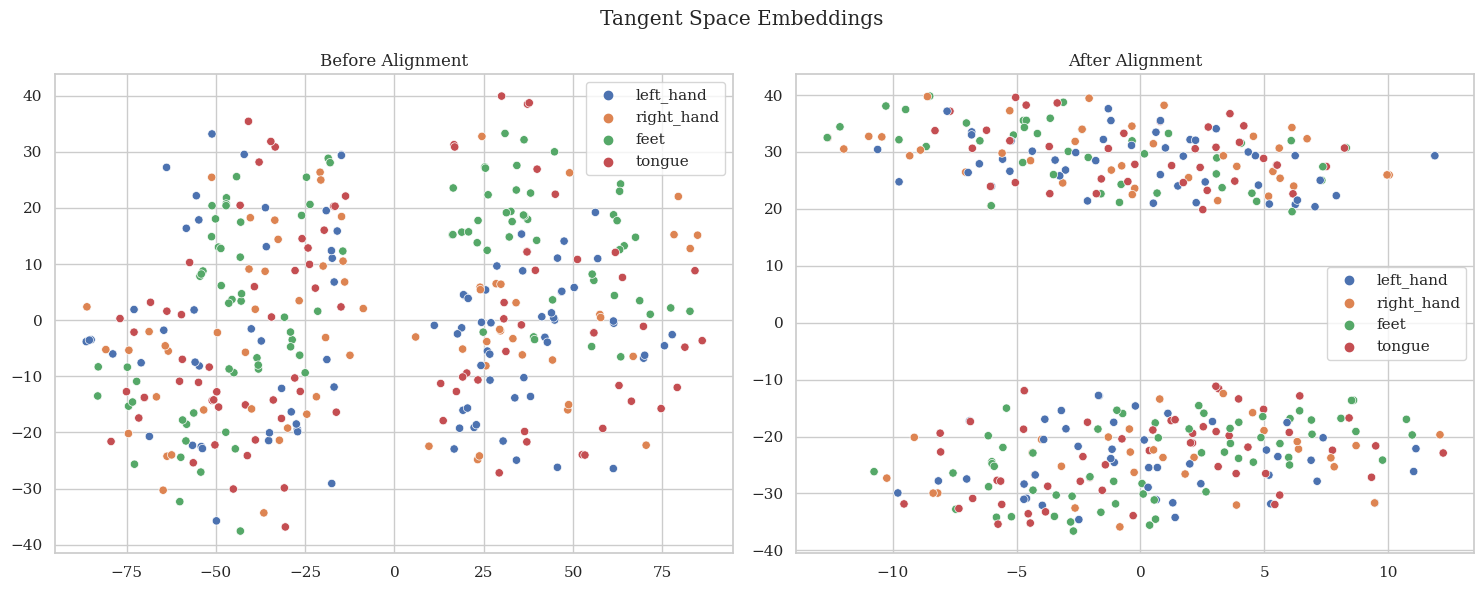

In [9]:
import numpy as np
import mne
import moabb
from moabb.datasets import BNCI2014001
from moabb.paradigms import MotorImagery
from sklearn.model_selection import train_test_split
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_riemann
from pyriemann.utils.tangentspace import tangent_space
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.manifold import TSNE

# Set random seed for reproducibility
np.random.seed(42)

# Initialize dataset and paradigm
dataset = BNCI2014001()
paradigm = MotorImagery(n_classes=4)

# Parameters for the sliding window
window_size = 2.0  # 2 second window
overlap = 0.5      # 50% overlap
sample_rate = 250  # Hz

def preprocess_data(X, y, window_samples, overlap_samples):
    """
    Apply sliding window to the data
    """
    n_channels = X.shape[1]
    n_samples = X.shape[2]
    
    # Calculate number of windows
    step = int(window_samples * (1 - overlap))
    n_windows = (n_samples - window_samples) // step + 1
    
    # Initialize arrays for windowed data
    X_windowed = np.zeros((X.shape[0] * n_windows, n_channels, window_samples))
    y_windowed = np.repeat(y, n_windows)
    
    # Apply sliding window
    for i in range(X.shape[0]):
        for j in range(n_windows):
            start = j * step
            end = start + window_samples
            X_windowed[i * n_windows + j] = X[i, :, start:end]
    
    return X_windowed, y_windowed

def compute_augmented_covariance(X):
    """
    Compute augmented covariance matrices
    """
    n_trials, n_channels, n_samples = X.shape
    
    # Compute mean trial for each channel
    X_mean = np.mean(X, axis=0)
    
    # Stack trials with mean
    X_aug = np.concatenate([X, np.tile(X_mean, (n_trials, 1, 1))], axis=1)
    
    # Compute covariance matrices
    cov = Covariances(estimator='scm').transform(X_aug)
    
    return cov

from scipy import linalg

def align_tangent_space(source_cov, target_cov):
    """
    Align source and target covariance matrices in tangent space with numerical stability
    """
    # Add small regularization to avoid numerical instabilities
    eps = 1e-10
    
    # Compute Riemannian mean as reference point
    reference = mean_riemann(np.concatenate([source_cov, target_cov]))
    
    # Project to tangent space
    source_ts = tangent_space(source_cov, reference)
    target_ts = tangent_space(target_cov, reference)
    
    # Compute class means with regularization
    n_classes = len(np.unique(y_train))
    source_means = np.zeros((n_classes, source_ts.shape[1]))
    target_means = np.zeros((n_classes, target_ts.shape[1]))
    
    # Compute robust means for each class
    for i in range(n_classes):
        source_class = source_ts[y_train == i]
        target_class = target_ts[y_test == i]
        
        # Remove any NaN or infinite values
        source_class = source_class[np.isfinite(source_class).all(axis=1)]
        target_class = target_class[np.isfinite(target_class).all(axis=1)]
        
        if len(source_class) > 0 and len(target_class) > 0:
            # Add regularization to means
            source_means[i] = np.mean(source_class, axis=0) + eps * np.eye(source_ts.shape[1])[0]
            target_means[i] = np.mean(target_class, axis=0) + eps * np.eye(target_ts.shape[1])[0]
    
    # Normalize means to improve conditioning
    source_means = source_means / (np.linalg.norm(source_means) + eps)
    target_means = target_means / (np.linalg.norm(target_means) + eps)
    
    # Compute cross-product matrix with regularization
    C = source_means.T @ target_means + eps * np.eye(source_means.shape[1])
    
    try:
        # Use more stable SVD algorithm
        U, S, V = linalg.svd(C, lapack_driver='gesvd', full_matrices=False)
        
        # Keep only significant singular values
        threshold = 1e-10
        rank = np.sum(S > threshold * S[0])
        U = U[:, :rank]
        V = V[:rank]
        
        # Compute rotation matrix
        R = U @ V
        
        # Apply rotation
        target_aligned = target_ts @ R.T
        
        return source_ts, target_aligned
        
    except ValueError as e:
        print(f"SVD failed: {str(e)}")
        # Return unaligned spaces as fallback
        return source_ts, target_ts





# Get data from MOABB
subjects = dataset.subject_list[1:2]  # Using first 3 subjects for demonstration
X_all = []
y_all = []

for subject in subjects:
    X, y, _ = paradigm.get_data(dataset=dataset, subjects=[subject])
    X_all.append(X)
    y_all.append(y)

# Process first subject as source
X_source = X_all[0]
y_source = y_all[0]

# Convert samples to time points
window_samples = int(window_size * sample_rate)
overlap_samples = int(window_samples * overlap)

# Apply sliding window
X_source_windowed, y_source_windowed = preprocess_data(X_source, y_source, 
                                                      window_samples, overlap_samples)

# Compute augmented covariance matrices
source_cov = compute_augmented_covariance(X_source_windowed)

# Split into train and test
source_train_cov, source_test_cov, y_train, y_test = train_test_split(
    source_cov, y_source_windowed, test_size=0.2, random_state=42
)

# Align tangent spaces
source_ts_train, source_ts_test = align_tangent_space(source_train_cov, source_test_cov)

# Train SVM classifier
clf = SVC(kernel='linear', random_state=42)
clf.fit(source_ts_train, y_train)

# Predict and evaluate
y_pred = clf.predict(source_ts_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy: {accuracy:.3f}")

# Visualize embeddings using t-SNE
def plot_embeddings(before_ts, after_ts, labels, title):
    """
    Visualize tangent space embeddings using t-SNE
    """
    tsne = TSNE(n_components=2, random_state=42)
    
    # Transform data
    before_2d = tsne.fit_transform(before_ts)
    after_2d = tsne.fit_transform(after_ts)
    
    # Verify and adjust lengths
    min_length = min(len(before_2d), len(after_2d), len(labels))
    before_2d = before_2d[:min_length]
    after_2d = after_2d[:min_length]
    labels = labels[:min_length]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot before alignment
    sns.scatterplot(x=before_2d[:, 0], y=before_2d[:, 1], 
                   hue=labels, ax=ax1, palette='deep')
    ax1.set_title('Before Alignment')
    
    # Plot after alignment
    sns.scatterplot(x=after_2d[:, 0], y=after_2d[:, 1], 
                   hue=labels, ax=ax2, palette='deep')
    ax2.set_title('After Alignment')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Visualize embeddings
plot_embeddings(source_ts_train, source_ts_test, 
               y_train, "Tangent Space Embeddings")
